## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.set_palette("Set2")
from matplotlib import rc

rc('text', usetex=False)

## Specify experiment directory

In [3]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Nikon_liveON/' #master folder

## Make dictionary for storing results and load images

In [4]:
results = {"path":[],
           "expname":[],
           "exp_date":[],
           "cell_no":[],
           "exp_condition":[],
           "timepoint":[],
           "soma_masked_image":[],
           "values_under_soma_mask":[],
           "background from full images":[],
          "values_soma_after_bg_subtraction":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "Analyze" in str(filelist[i]):
        if ("bg_value" in str(filelist[i]))==True:
            if ("linescan" in str(filelist[i]))==False:
                if filelist[i].endswith(".mat"): 
                    results["path"].append(filelist[i])
                    results["expname"].append(filelist[i].split('/')[-2])
                    results["exp_date"].append(filelist[i].split('/')[-2][0:6])
                    results["cell_no"].append(filelist[i].split('/')[-1][-14:-13])
                    if ("Blocked_plus4hrs" in str(filelist[i]))==True:
                        results["exp_condition"].append("Blocked")
                    elif ("All_epitopes" in str(filelist[i]))==True:
                        results["exp_condition"].append("Unblocked")

                    results["timepoint"].append(filelist[i].split('/')[-1][-21:-20])

                    #soma
                    firstpart=filelist[i][:-12]
                    file2read=firstpart+'maskedimage.mat'
                    results["soma_masked_image"].append(np.asarray(spio.loadmat(file2read)["masked_image"]))
                    file2read=firstpart+'image_under_mask.mat'
                    results["values_under_soma_mask"].append(np.asarray(spio.loadmat(file2read)["undermask"]))
                    results["background from full images"].append(np.asarray(spio.loadmat(filelist[i])["bg"]))
                    #soma - bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["undermask"])
                    bg=np.asarray(spio.loadmat(filelist[i])["bg"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    results["values_soma_after_bg_subtraction"].append(bgsubtracted)

## Make a dataframe of the results

In [7]:
df=pd.DataFrame(results)
df['timepoint']=df['timepoint'].apply(int)
df['cell_no']=df['cell_no'].apply(int)
df["soma mean intensity after bg subtract"]=[np.mean(x) for x in df["values_soma_after_bg_subtraction"]]
df["soma mean intensity"]=[np.mean(x) for x in df["values_under_soma_mask"]]

## Normalize the values to the first timepoint

In [8]:
#normalized values (divided by first time point)
df["normd soma mean intensity after bg subtract"]=df["soma mean intensity after bg subtract"]
df["normd soma mean intensity"]=df["soma mean intensity"]
for exp in df["expname"].unique():
    for cell in df[df["expname"]==exp]["cell_no"].unique(): 
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity after bg subtract"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity after bg subtract"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity after bg subtract"]/firsttimepoint.values[0]
        
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity"]/firsttimepoint.values[0]

## Make dataframes for blocked and unblocked, means of individual experiments

In [12]:
expsblocked={"blockedmean":[],"blockedtimepoint":[],"blockedexpname":[]}
expsunblocked={"unblockedmean":[],"unblockedtimepoint":[],"unblockedexpname":[]}
for exp in df["expname"].unique():
    dfexp=df[df["expname"]==exp]
    if dfexp["exp_condition"].unique()[0]=="Blocked":        
        for time in range(1,9):
            expsblocked["blockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsblocked["blockedtimepoint"].append(time)
            expsblocked["blockedmean"].append(dftime["normd soma mean intensity after bg subtract"].values.mean())
    if dfexp["exp_condition"].unique()[0]=="Unblocked":        
        for time in range(1,9):
            expsunblocked["unblockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsunblocked["unblockedtimepoint"].append(time)
            expsunblocked["unblockedmean"].append(dftime["normd soma mean intensity after bg subtract"].values.mean())
dfblocked=pd.DataFrame(expsblocked)
dfunblocked=pd.DataFrame(expsunblocked)
dfblocked.loc[dfblocked["blockedtimepoint"]==1,"blockedtimepoint"]=0
dfunblocked.loc[dfunblocked["unblockedtimepoint"]==1,"unblockedtimepoint"]=0

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()


## Number of cells in each experiment

In [29]:
dfi=df[df["exp_condition"]=="Unblocked"]
for exp in dfi["expname"].unique():
    dfmeasure=dfi[dfi["expname"]==exp]
    print(exp)
    print('no. cells: '+str(len(dfmeasure["cell_no"].unique())))

20190304_tnrunblocked
no. cells: 2
190224_ON_tnr550_notblocked
no. cells: 1
20190227_tnrunblocked550phenolredON
no. cells: 4
20190301_tnrunblockedON_phenolred
no. cells: 1
20190311_TNR550unblocked
no. cells: 2


In [30]:
dfi=df[df["exp_condition"]=="Blocked"]
for exp in dfi["expname"].unique():
    dfmeasure=dfi[dfi["expname"]==exp]
    print(exp)
    print('no. cells: '+str(len(dfmeasure["cell_no"].unique())))

20190303_tnrblockedplus4_ON
no. cells: 1
20190302_tnrblockedplus4_ON
no. cells: 4
190217_Trial3_100xLiveTNR580syt488_postblocking_4hrs
no. cells: 3
20190228_tnrblocked4hrON_phenolred
no. cells: 1
20190313_TNR550blocked
no. cells: 2


## ttest at 4 hours

In [31]:
control=dfunblocked[dfunblocked["unblockedtimepoint"]==4]["unblockedmean"].values
Blocked=dfblocked[dfblocked["blockedtimepoint"]==4]["blockedmean"].values
[stat,pval]=stats.ttest_ind(control, Blocked)
print(pval)

0.04232395190214306


## Plot

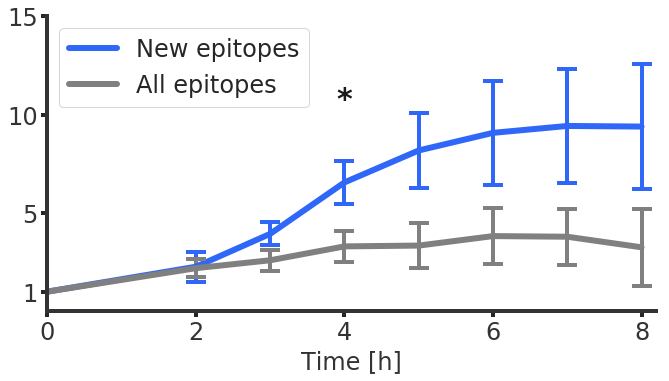

In [33]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
plt.rcParams['font.sans-serif'] = 'Helvetica'

var="blockedmean"
var2="unblockedmean"

fig=plt.figure(figsize=(10,6))
g=sns.lineplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=6,color="#2F67F8",ci=None);
g=sns.lineplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=6,color='grey',ci=None);

g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfblocked[dfblocked["blockedtimepoint"]==1][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].mean()],
             yerr=[dfblocked[dfblocked["blockedtimepoint"]==1][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].sem()],
             xerr=None,ecolor="#2F67F8",fmt='none',capsize=10,linewidth=4,capthick=4)

g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].mean()],
             yerr=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].sem()],
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=4,capthick=4)
col='k'
y=10
h=0
x1,x2=3,5
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')

#formatting
plt.title('')
plt.locator_params(axis='y', nbins=5)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
g.spines['bottom'].set_linewidth(3)
g.spines['left'].set_linewidth(3)
plt.xticks(size = 24,color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
g.set_ylabel('',size=24,labelpad=5,color='#333333')
g.set_xlabel('Time [h]',size=24,labelpad=5,color='#333333')
g.grid(False)
plt.xlim([0,8.2])
plt.ylim([0,15])
plt.yticks([1,5,10,15],size = 24,color='#333333')
plt.xticks([0,2,4,6,8],size = 24,color='#333333')


plt.legend(['New epitopes','All epitopes'],fontsize=24)
plt.tight_layout()

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'figure4a_endocytosis_nikon.svg', bbox_inches='tight', format='svg')